## Importar Dataset

In [ ]:
import os
import ast
from google.colab import drive
drive.mount('/content/drive')
os.listdir('/content/drive/MyDrive/')
# method in Python used to change the current working directory to the specified path.
path = "/content/drive/MyDrive/Artigos_IC/"
os.chdir(path)
import shutil
shutil.copy('/content/drive/MyDrive/Artigos_IC/out_clean.csv', '/content/')

Mounted at /content/drive


'/content/out_clean.csv'

## Importanto bibliotecas para o Deep Learning

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, multilabel_confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from keras import regularizers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf


In [ ]:
df = pd.read_csv('/content/out_clean.csv', index_col=0)
df.columns=df.columns.str.replace(' ','_')
# Ensure that the `smell` column is interpreted as a string
df['agreement_experts_has_smell_name'] = df['agreement_experts_has_smell_name'].astype(str)
df = df[df['agreement_experts_has_smell_name'] != 'none']
smell = df['agreement_experts_has_smell_name']

## start variables

In [ ]:
# Step 2: Separate Features (X) and Labels (y)
# Assuming 'longmethod', 'feature_envy', 'dataclass', and 'blob' are the label columns.
X = df[['longmethod_label', 'featureenvy_label','ck_method_cbo','ck_class_cbo','ck_class_fanin']]
y = smell
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = one_hot_encoder.fit_transform(y.values.reshape(-1, 1))

num_classes = len(one_hot_encoder.categories_)
# Step 3: Split into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)



#  GRU,CNN, LSTM e MLP

In [ ]:
# Step 4: Scale the Features (Standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Reshape data for CNN and LSTM (if needed)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Step 5a: MLP Model
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')  # Sigmoid for multi-label classification
])
mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
mlp_history = mlp_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

# Step 5b: CNN Model
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')
])
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
cnn_history = cnn_model.fit(
    X_train_cnn, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

# Step 5c: LSTM Model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5190 - loss: 0.5728 - val_accuracy: 0.7564 - val_loss: 0.2623 - learning_rate: 0.0010
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7119 - loss: 0.2677 - val_accuracy: 0.7639 - val_loss: 0.2229 - learning_rate: 0.0010
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7275 - loss: 0.2423 - val_accuracy: 0.7624 - val_loss: 0.2183 - learning_rate: 0.0010
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7382 - loss: 0.2338 - val_accuracy: 0.7519 - val_loss: 0.2163 - learning_rate: 0.0010
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7583 - loss: 0.2235 - val_accuracy: 0.7609 - val_loss: 0.2121 - learning_rate: 0.0010
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7578 - loss: 0.2232 - val_accuracy: 0.7639 - val_loss: 0.2119 - learning_rate: 0.0010
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7536 - loss: 0.2218 - val_accuracy: 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3587 - loss: 0.6202 - val_accuracy: 0.6571 - val_loss: 0.4334 - learning_rate: 0.0010
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6771 - loss: 0.4030 - val_accuracy: 0.6872 - val_loss: 0.3070 - learning_rate: 0.0010
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6911 - loss: 0.3007 - val_accuracy: 0.7143 - val_loss: 0.2651 - learning_rate: 0.0010
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7132 - loss: 0.2747 - val_accuracy: 0.7173 - val_loss: 0.2504 - learning_rate: 0.0010
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7317 - loss: 0.2604 - val_accuracy: 0.7098 - val_loss: 0.2437 - learning_rate: 0.0010
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7218 - loss: 0.2514 - val_accuracy: 0.7414 - val_loss: 0.2387 - learning_rate: 0.0010
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7247 - loss: 0.2509 - val_accuracy: 0.7414 - va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4642 - loss: 0.6118 - val_accuracy: 0.6737 - val_loss: 0.2828 - learning_rate: 0.0010
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6840 - loss: 0.2794 - val_accuracy: 0.6902 - val_loss: 0.2237 - learning_rate: 0.0010
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6785 - loss: 0.2460 - val_accuracy: 0.7579 - val_loss: 0.2143 - learning_rate: 0.0010
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7163 - loss: 0.2313 - val_accuracy: 0.7579 - val_loss: 0.2118 - learning_rate: 0.0010
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7240 - loss: 0.2248 - val_accuracy: 0.7609 - val_loss: 0.2097 - learning_rate: 0.0010
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7513 - loss: 0.2208 - val_accuracy: 0.7699 - val_loss: 0.2078 - learning_rate: 0.0010
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7394 - loss: 0.2254 - val_accuracy: 0.763

In [ ]:
# Redimensionar os dados para 3D
X_train_gru = np.expand_dims(X_train, axis=1)  # (batch_size, time_steps=1, feature_dim=num_features)
X_test_gru = np.expand_dims(X_test, axis=1)

# Build GRU model
model_gru = Sequential([
    Input(shape=(X_train_gru.shape[1], X_train_gru.shape[2])),  # (time_steps, feature_dim)
    GRU(128, activation='relu', return_sequences=False),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='sigmoid')  # Ajustado para multi-label classification
])

# Compile model
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training model
history_gru = model_gru.fit(X_train_gru, y_train, epochs=10, batch_size=4, verbose=1)

Epoch 1/10
831/831 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6862 - loss: 0.3486
Epoch 2/10
831/831 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7491 - loss: 0.2117
Epoch 3/10
831/831 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7473 - loss: 0.2181
Epoch 4/10
831/831 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7686 - loss: 0.2094
Epoch 5/10
831/831 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7710 - loss: 0.2062
Epoch 6/10
831/831 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7589 - loss: 0.2110
Epoch 7/10
831/831 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7635 - loss: 0.2091
Epoch 8/10
831/831 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7410 - loss: 0.2144
Epoch 9/10
831/831 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7576 - loss: 0.2099
Epoch 10/10
831/831 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7652 - loss: 0.2112


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Model: MLP
Classification Report:
              precision    recall  f1-score   support

        blob       0.66      0.61      0.63       283
   dataclass       0.59      0.67      0.63       248
 featureenvy       1.00      1.00      1.00       159
  longmethod       1.00      1.00      1.00       141

   micro avg       0.76      0.77      0.76       831
   macro avg       0.81      0.82      0.82       831
weighted avg       0.76      0.77      0.77       831
 samples avg       0.76      0.77      0.77       831

Acurácia
0.7581227436823105


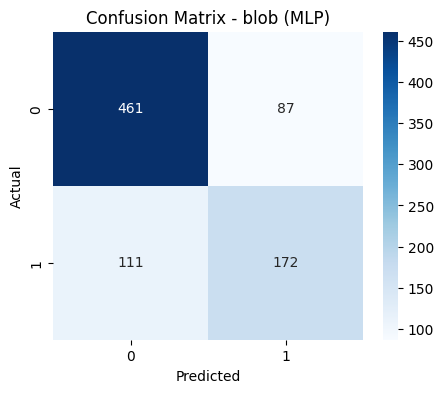

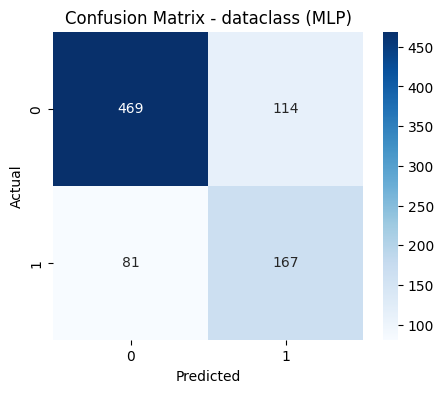

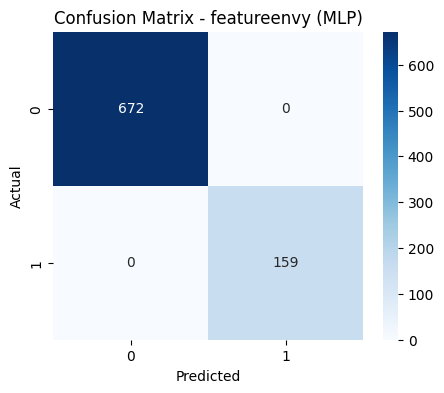

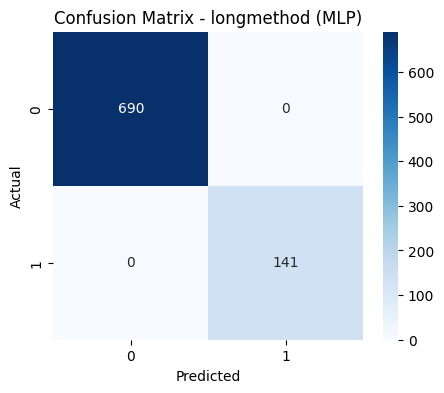

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Model: CNN
Classification Report:
              precision    recall  f1-score   support

        blob       0.69      0.63      0.66       283
   dataclass       0.60      0.71      0.65       248
 featureenvy       1.00      1.00      1.00       159
  longmethod       1.00      1.00      1.00       141

   micro avg       0.77      0.79      0.78       831
   macro avg       0.82      0.83      0.83       831
weighted avg       0.78      0.79      0.78       831
 samples avg       0.77      0.79      0.78       831

Acurácia
0.762936221419976


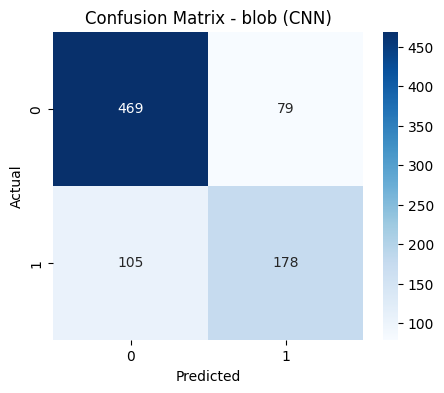

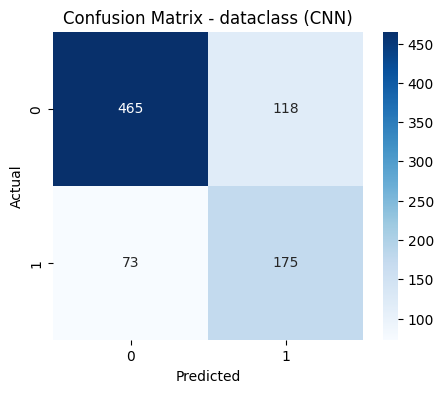

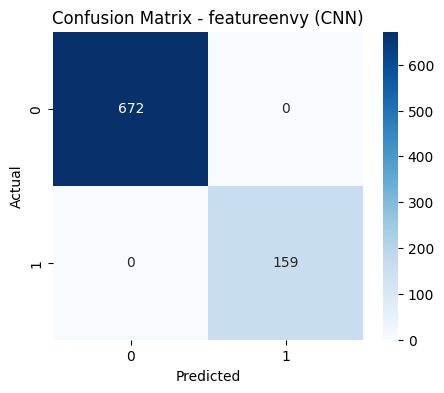

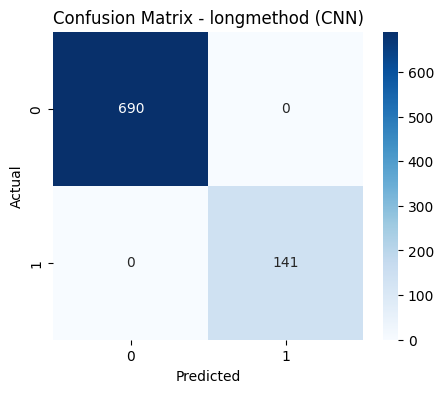

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Model: LSTM
Classification Report:
              precision    recall  f1-score   support

        blob       0.69      0.64      0.66       283
   dataclass       0.61      0.67      0.64       248
 featureenvy       1.00      1.00      1.00       159
  longmethod       1.00      1.00      1.00       141

   micro avg       0.78      0.78      0.78       831
   macro avg       0.82      0.83      0.83       831
weighted avg       0.78      0.78      0.78       831
 samples avg       0.78      0.78      0.78       831

Acurácia
0.7737665463297232


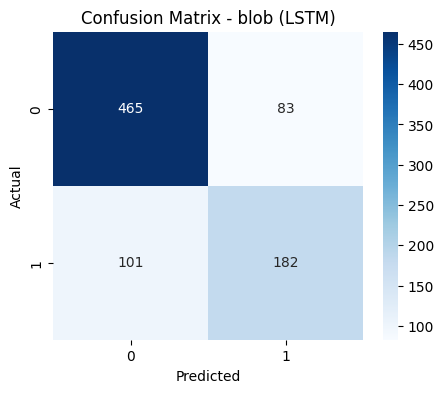

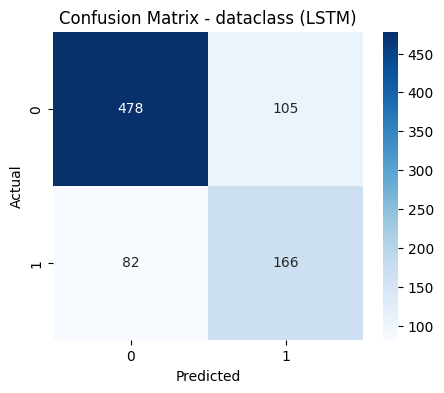

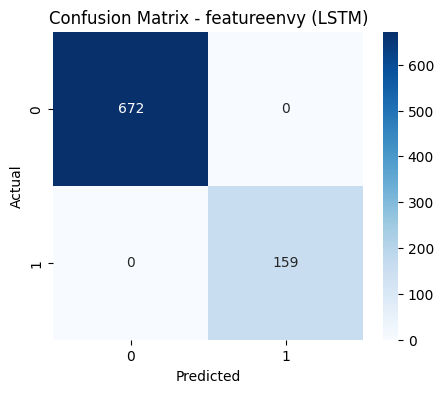

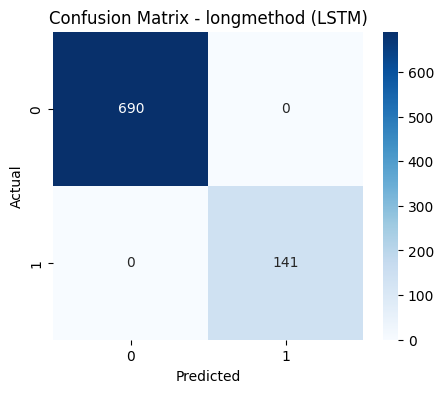

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Model: GRU
Classification Report:
              precision    recall  f1-score   support

        blob       0.68      0.60      0.64       283
   dataclass       0.59      0.67      0.63       248
 featureenvy       1.00      1.00      1.00       159
  longmethod       1.00      1.00      1.00       141

   micro avg       0.76      0.77      0.77       831
   macro avg       0.82      0.82      0.82       831
weighted avg       0.77      0.77      0.77       831
 samples avg       0.76      0.77      0.77       831

Acurácia
0.762936221419976


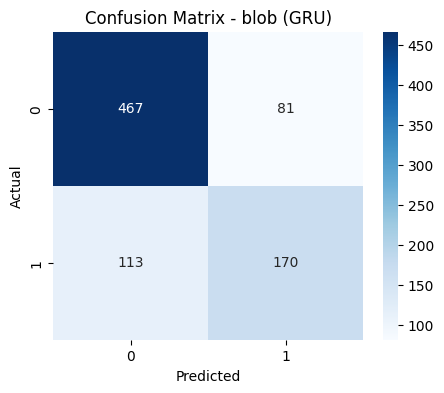

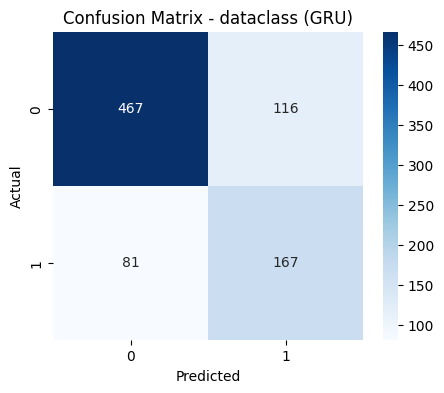

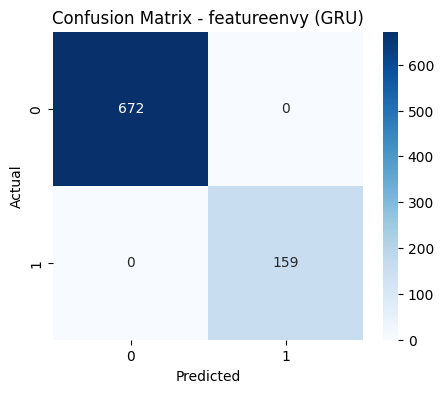

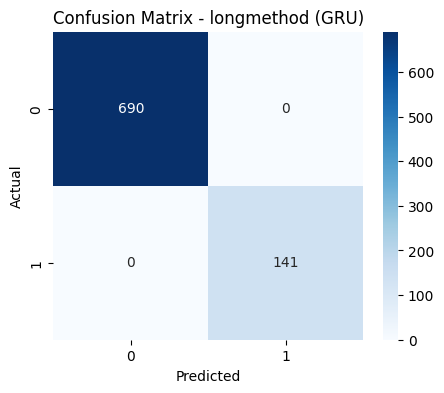

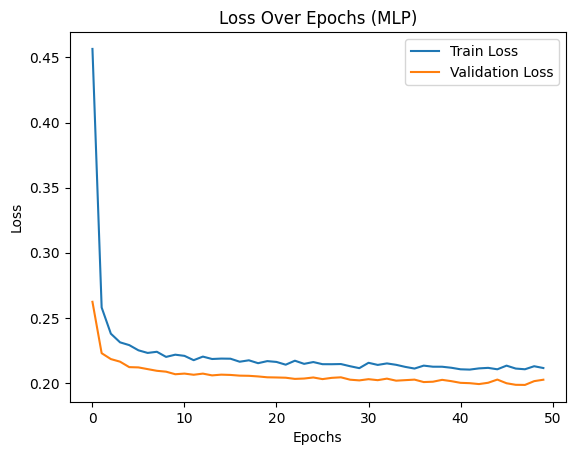

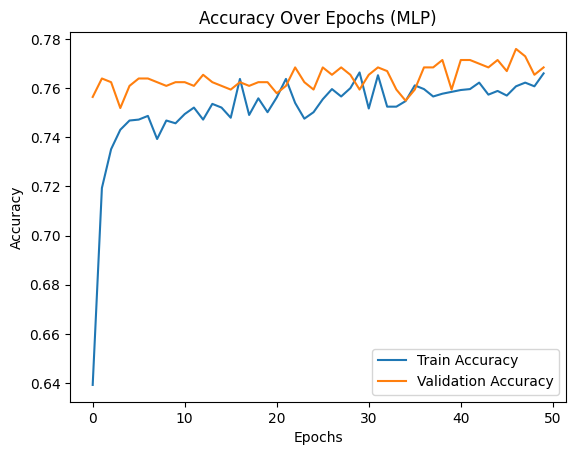

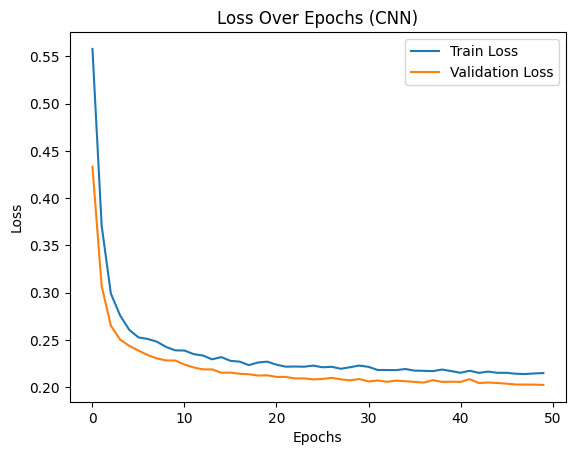

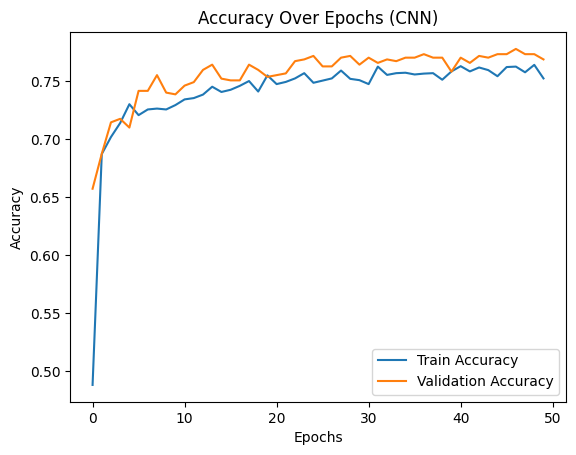

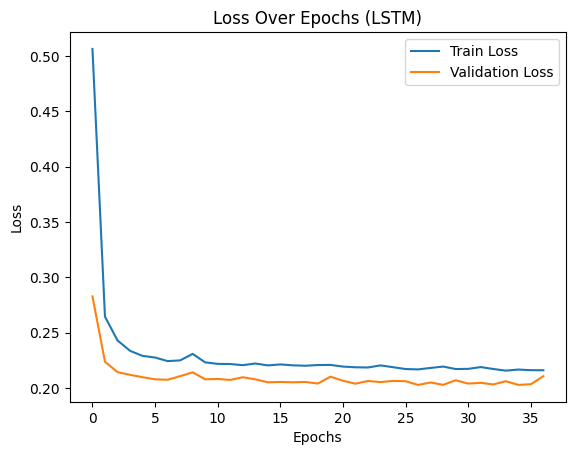

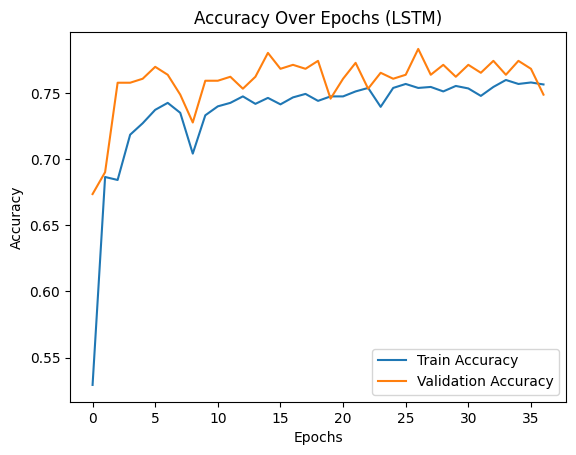

KeyError: 'val_loss'

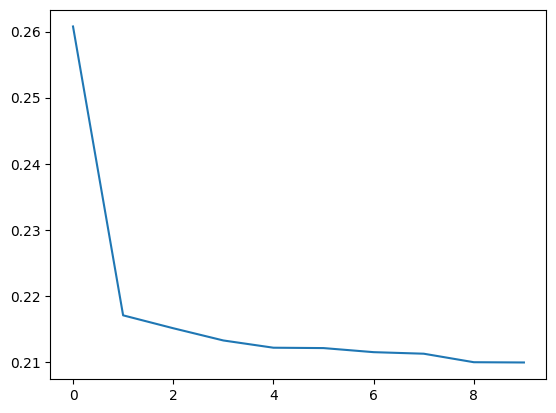

In [ ]:
# Step 6: Evaluate Models
def evaluate_model(model, X_test, y_test, model_name):
    if len(X_test.shape) == 2:  # For MLP
        predictions = model.predict(X_test)
    elif model_name=='CNN' or model_name=='LSTM':  # For CNN and LSTM
        predictions = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
    else:
        predictions = model.predict(X_test)
    predictions = (predictions > 0.5).astype(int)
    print(f"\nModel: {model_name}")
    print("Classification Report:")
    print(classification_report(y_test, predictions, target_names=one_hot_encoder.categories_[0]))
    print("Acurácia")
    print(accuracy_score(y_test, predictions))
    conf_matrix = multilabel_confusion_matrix(y_test, predictions)
    for i, label in enumerate(one_hot_encoder.categories_[0]):
        plt.figure(figsize=(5, 4))
        sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {label} ({model_name})')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

# Evaluate all models
evaluate_model(mlp_model, X_test, y_test, "MLP")
evaluate_model(cnn_model, X_test_cnn, y_test, "CNN")
evaluate_model(lstm_model, X_test_cnn, y_test, "LSTM")
evaluate_model(model_gru, X_test_gru, y_test, "GRU")
#evaluate_model(history_capsnet, X_test, y_test, "CapsuleNetworks")

# Step 7: Plot Training History
def plot_history(history, model_name):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f'Loss Over Epochs ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f'Accuracy Over Epochs ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

# Plot histories
plot_history(mlp_history, "MLP")
plot_history(cnn_history, "CNN")
plot_history(lstm_history, "LSTM")
plot_history(history_gru, "GRU")

# DeleSmell

In [ ]:
X_train = X_train.values.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1],1))

In [ ]:
units = 1
inp=Input(shape=(X_train.shape[1:]))

In [ ]:
x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
#x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = BatchNormalization()(x)
x = Conv1D(512, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(512, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
activations = Bidirectional(GRU(units,return_sequences = True,dropout=0.2,recurrent_dropout=0.2))(inp)
attention = Dense(1,activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units*2)(attention)
attention = Permute([2,1])(attention)
sent_representation = Multiply()( [activations,attention])
sent_representation = Lambda(lambda xin: K.sum(xin,axis=-2),output_shape=(units*2,))(sent_representation)

In [ ]:
l=Dense(128,activation="relu")(sent_representation)
l=Dropout(0.3)(l)
d = Flatten()(l)

In [ ]:
g2=concatenate([g,d],axis=1)
q=Dense(128)(g2)
q=LeakyReLU(alpha=0.33)(q)
q=LeakyReLU(alpha=0.33)(q)
q=LeakyReLU(alpha=0.33)(q)
q=Dropout(0.5)(q)
q=Dense(256,activation="tanh")(q)

In [ ]:
output = Dense(2, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='linear')(q)
model = Model(inputs=inp,outputs=output)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
              loss ='hinge',
              metrics = ['accuracy'])

In [ ]:
Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
predict = model.predict(X_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,target_names=one_hot_encoder.categories_[0]))

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
              precision    recall  f1-score   support

        blob       0.44      0.76      0.56       283
   dataclass       0.19      0.27      0.23       248
 featureenvy       0.00      0.00      0.00       159
  longmethod       0.00      0.00      0.00       141

    accuracy                           0.34       831
   macro avg       0.16      0.26      0.20       831
weighted avg       0.21      0.34      0.26       831



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Auto Keras

In [ ]:
!pip3 install autokeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.8 MB/s eta 0:00:00


In [ ]:

import tensorflow as tf
import autokeras as ak


X = df[['longmethod_label', 'featureenvy_label','ck_method_cbo','ck_class_cbo','ck_class_fanin']]
y = smell



# Coding the labels for numerical values
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = one_hot_encoder.fit_transform(y.values.reshape(-1, 1))

# Split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize numerical characteristics
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

# Configuring AutoModel
input_node = ak.Input()
output_node =ak.ClassificationHead()
# Create model
clf = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
    max_trials=15  # Define how many models will be tested
)

# Training model
clf.fit(x=X_train, y=y_train, epochs=20, validation_split=0.2, batch_size=8)

# Evaluate model
accuracy = clf.evaluate(X_test, y_test)
print(f"Acurácia no conjunto de teste: {accuracy[1]:.4f}")

# Making predictions
y_pred = clf.predict(X_test).flatten()



Trial 15 Complete [00h 01m 29s]
val_loss: 0.3969348669052124

Best val_loss So Far: 0.3969348669052124
Total elapsed time: 00h 12m 06s
Epoch 1/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6965 - loss: 0.5801
Epoch 2/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7431 - loss: 0.4369
Epoch 3/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7444 - loss: 0.4311
Epoch 4/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7562 - loss: 0.4289
Epoch 5/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7576 - loss: 0.4264
Epoch 6/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7624 - loss: 0.4246
Epoch 7/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7643 - loss: 0.4232
Epoch 8/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7635 - loss: 0.4222
Epoch 9/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7661 - loss: 0.4212
Epoch 10/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7632 - loss: 0.454

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7853 - loss: 0.3789
Acurácia no conjunto de teste: 0.7702
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 5))
  warnings.warn(msg)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
y_pred = clf.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Step 10: Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=one_hot_encoder.categories_[0]))

# tuner AutoModel
tuner = clf.tuner

best_trials = tuner.oracle.get_best_trials(num_trials=10)  # best top 10 model

for i, trial in enumerate(best_trials):
    print(f"\nModelo {i+1}:")
    print("Hiperparâmetros:")
    for param, value in trial.hyperparameters.values.items():
        print(f"  {param}: {value}")

    model = tuner.hypermodel.build(trial.hyperparameters)
    print("\nResumo do Modelo:")
    model.summary()


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Classification Report:

              precision    recall  f1-score   support

        blob       0.69      0.58      0.63       283
   dataclass       0.60      0.71      0.65       248
 featureenvy       1.00      1.00      1.00       159
  longmethod       1.00      1.00      1.00       141

   micro avg       0.77      0.77      0.77       831
   macro avg       0.82      0.82      0.82       831
weighted avg       0.78      0.77      0.77       831
 samples avg       0.77      0.77      0.77       831


Modelo 1:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 3
  general_block_1/dense_block_1/units_0: 512
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 1024
  classification_head_1/dropout: 0
  optimizer: adam
  learning_rate: 0.001
  general_block_1/dense_block_1/units_2: 16

Resumo do Modelo:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_1 (CastToFloat32)    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,380 (5.39 KB)

 Trainable params: 1,380 (5.39 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 2:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 3
  general_block_1/dense_block_1/units_0: 512
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 1024
  classification_head_1/dropout: 0
  optimizer: adam
  learning_rate: 0.001
  general_block_1/dense_block_1/units_2: 32

Resumo do Modelo:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_2 (Cast)                        │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_2 (CastToFloat32)    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,380 (5.39 KB)

 Trainable params: 1,380 (5.39 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 3:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 3
  general_block_1/dense_block_1/units_0: 512
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 256
  classification_head_1/dropout: 0
  optimizer: adam
  learning_rate: 0.001
  general_block_1/dense_block_1/units_2: 32

Resumo do Modelo:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_3 (Cast)                        │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_3 (CastToFloat32)    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_8 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 4)                   │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,380 (5.39 KB)

 Trainable params: 1,380 (5.39 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 4:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 3
  general_block_1/dense_block_1/units_0: 32
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 1024
  classification_head_1/dropout: 0
  optimizer: adam
  learning_rate: 0.001
  general_block_1/dense_block_1/units_2: 32

Resumo do Modelo:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_4 (Cast)                        │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_4 (CastToFloat32)    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_9 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_10 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4)                   │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,380 (5.39 KB)

 Trainable params: 1,380 (5.39 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 5:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 3
  general_block_1/dense_block_1/units_0: 32
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 32
  classification_head_1/dropout: 0
  optimizer: adam
  learning_rate: 0.001
  general_block_1/dense_block_1/units_2: 32

Resumo do Modelo:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_5 (Cast)                        │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_5 (CastToFloat32)    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_11 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_12 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 4)                   │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,380 (5.39 KB)

 Trainable params: 1,380 (5.39 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 6:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 3
  general_block_1/dense_block_1/units_0: 512
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 128
  classification_head_1/dropout: 0
  optimizer: adam
  learning_rate: 0.001
  general_block_1/dense_block_1/units_2: 32

Resumo do Modelo:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_6 (Cast)                        │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_6 (CastToFloat32)    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_13 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_14 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 4)                   │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,380 (5.39 KB)

 Trainable params: 1,380 (5.39 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 7:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 3
  general_block_1/dense_block_1/units_0: 32
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 64
  classification_head_1/dropout: 0
  optimizer: adam
  learning_rate: 0.001
  general_block_1/dense_block_1/units_2: 32

Resumo do Modelo:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_7 (Cast)                        │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_7 (CastToFloat32)    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_15 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_16 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 4)                   │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,380 (5.39 KB)

 Trainable params: 1,380 (5.39 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 8:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 32
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 32
  classification_head_1/dropout: 0
  optimizer: adam
  learning_rate: 0.001

Resumo do Modelo:


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_8 (Cast)                        │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_8 (CastToFloat32)    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_17 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_18 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 4)                   │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,380 (5.39 KB)

 Trainable params: 1,380 (5.39 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 9:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 3
  general_block_1/dense_block_1/units_0: 512
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 16
  classification_head_1/dropout: 0
  optimizer: adam
  learning_rate: 0.001
  general_block_1/dense_block_1/units_2: 32

Resumo do Modelo:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_9 (Cast)                        │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_9 (CastToFloat32)    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_19 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_20 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 4)                   │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,380 (5.39 KB)

 Trainable params: 1,380 (5.39 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 10:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 32
  general_block_1/dense_block_1/dropout: 0.25
  general_block_1/dense_block_1/units_1: 32
  classification_head_1/dropout: 0
  optimizer: adam
  learning_rate: 0.001

Resumo do Modelo:


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_10 (Cast)                       │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_10 (CastToFloat32)   │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_21 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_22 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 4)                   │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,380 (5.39 KB)

 Trainable params: 1,380 (5.39 KB)

 Non-trainable params: 0 (0.00 B)